In [1]:
import os

# --- A Better Way to Verify Paths ---

file_count = 0
print("--- Verifying file paths (showing first 20 as an example) ---")

# The path has been corrected to one level up
for dirname, _, filenames in os.walk('/kaggle/input/multimodel-emotion-data/'):
    for filename in filenames:
        # The condition is now correctly set to '< 20'
        if file_count < 20:
            print(os.path.join(dirname, filename))
        file_count += 1

print("\n...")
print(f"✅ Verification complete. Total files found: {file_count}")

--- Verifying file paths (showing first 20 as an example) ---
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/speech_features.pkl
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/Paper.ipynb
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/Research Paper.ipynb
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/DEAP (EEG)/deap-dataset/The DEAP.txt
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/DEAP (EEG)/deap-dataset/EDA_DEAP.ipynb
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/DEAP (EEG)/deap-dataset/data_preprocessed_python/s20.dat
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/DEAP (EEG)/deap-dataset/data_preprocessed_python/s17.dat
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/DEAP (EEG)/deap-dataset/data_preprocessed_python/s31.dat
/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/DEAP (EEG)/deap-dataset/data_preprocessed_python/s14.dat
/kaggle/input/multimode

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 90.2 MB/s eta 0:00:00:00:0100:01


In [3]:
# ==============================================================================
#                      MAIN RESEARCH SCRIPT
#  Quantum Cognitive Computing for Multimodal Emotion Recognition
# ==============================================================================

# --------------------------------------------------------------------------
## 1. SETUP AND IMPORTS
# --------------------------------------------------------------------------
import os
import pickle
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix

import pennylane as qml
from pennylane import numpy as np

import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertModel, BertTokenizer

# --- Configuration ---
warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# Set base path to the current folder, since the notebook is inside Datasets
# Use this corrected path in your main script
BASE_PATH = '/kaggle/input/multimodel-emotion-data/multimodal-emotion-data/'


2025-08-09 04:14:49.502419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754712889.722299      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754712889.785830      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [4]:

# --------------------------------------------------------------------------
## 2. DATA LOADING & PREPROCESSING FUNCTIONS
#
# These functions are tailored to your specific folder structures.
# --------------------------------------------------------------------------

def load_text_data(path=os.path.join(BASE_PATH, 'Emotion Detection using TEXT/emotion_dataset_raw.csv')):
    """Loads and preprocesses the text data from your CSV file."""
    print("Loading text data...")
    df = pd.read_csv(path)
    # The CSV has 'Emotion' and 'Text' columns, which is perfect.
    texts = df['Text'].tolist()
    labels = df['Emotion'].tolist()
    
    # Encode labels to integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    # Tokenize text
    tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
    inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=64, return_tensors="pt")
    
    print(f"Text data loaded. Found {len(texts)} samples.")
    return inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels_encoded, dtype=torch.long), label_encoder

def load_image_data(path='/kaggle/input/fer2013/'): # Updated path
    """
    Loads the image data from the complete FER-2013 dataset.
    """
    print("Loading image data from FER-2013 dataset...")
    
    # Define transformations. FER-2013 images are grayscale, so we convert to RGB.
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3-channel RGB
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_dataset = ImageFolder(root=os.path.join(path, 'train'), transform=transform)
    test_dataset = ImageFolder(root=os.path.join(path, 'test'), transform=transform)
    
    print(f"Image data loaded. Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples.")
    return train_dataset, test_dataset
    
from tqdm import tqdm # Make sure this is imported

def load_ved_speech_data(path=os.path.join(BASE_PATH, 'VED (Speech)/Voice Emotion Dataset/'), use_subset=None):
    """
    Loads VED speech data. If a pre-processed file exists, it loads it.
    Otherwise, it processes the raw audio, saves the features, and returns them.
    """
    processed_file = os.path.join(BASE_PATH, 'VED (Speech)/ved_features.pt')

    # If a pre-processed file exists, load it and return instantly.
    if os.path.exists(processed_file):
        print(f"Loading pre-processed VED speech data from {processed_file}...")
        data = torch.load(processed_file)
        print("VED speech data loaded instantly.")
        return data['features'], data['labels']

    # If not, run the slow one-time processing.
    print("Pre-processed file not found. Starting one-time processing of VED audio files...")
    filepaths, labels = [], []
    label_map = {d: i for i, d in enumerate(os.listdir(path))}

    for emotion_folder, label_idx in label_map.items():
        folder_path = os.path.join(path, emotion_folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(".wav"):
                filepaths.append(os.path.join(folder_path, filename))
                labels.append(label_idx)

    # If use_subset is set, only process a small number of files for quick testing.
    if use_subset and isinstance(use_subset, int):
        print(f"--- USING SUBSET of {use_subset} files for development ---")
        filepaths = filepaths[:use_subset]
        labels = labels[:use_subset]

    # Feature extraction (MFCCs) with a progress bar.
    features = []
    for fp in tqdm(filepaths, desc="Processing VED audio files"):
        waveform, sr = librosa.load(fp, sr=16000)
        mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=40)
        if mfccs.shape[1] < 173:
            mfccs = np.pad(mfccs, ((0, 0), (0, 173 - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :173]
        features.append(mfccs)

    features = np.array(features)
    labels = np.array(labels)

    # Normalize features.
    scaler = StandardScaler()
    features = scaler.fit_transform(features.reshape(-1, features.shape[-1])).reshape(features.shape)

    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Save the processed data for next time.
    print(f"Saving processed features to {processed_file}...")
    torch.save({'features': features_tensor, 'labels': labels_tensor}, processed_file)
    print("Save complete.")

    return features_tensor, labels_tensor
    
def load_deap_eeg_data(path=os.path.join(BASE_PATH, 'DEAP (EEG)/deap-dataset/data_preprocessed_python/')):
    """Loads preprocessed DEAP EEG data."""
    print("Loading DEAP EEG data...")
    all_data, all_labels_v = [], []
    for i in range(1, 33): # s01.dat to s32.dat
        file_path = os.path.join(path, f"s{str(i).zfill(2)}.dat")
        with open(file_path, 'rb') as f:
            subject_data = pickle.load(f, encoding='latin1')
        all_data.append(subject_data['data']) # (40 trials, 32 channels, 8064 samples)
        all_labels_v.append(subject_data['labels'][:, 0]) # Valence labels

    all_data = np.vstack(all_data)
    all_labels_v = np.hstack(all_labels_v)
    
    # DEAP is complex. We'll simplify by taking a segment and binning labels.
    # Take first ~1 second of data from the 32 EEG channels
    eeg_features = all_data[:, :32, :128].reshape(all_data.shape[0], -1) 
    
    # Binarize Valence labels (e.g., low/high)
    eeg_labels = (all_labels_v > 5).astype(int)
    
    scaler = StandardScaler()
    eeg_features = scaler.fit_transform(eeg_features)
    
    print(f"DEAP EEG data loaded. Found {len(eeg_features)} samples.")
    return torch.tensor(eeg_features, dtype=torch.float32), torch.tensor(eeg_labels, dtype=torch.long)


In [5]:
# --------------------------------------------------------------------------
## 3. UNIFIED PYTORCH DATASET
#
# This class combines all your datasets into one.
# --------------------------------------------------------------------------
class UnifiedMultimodalDataset(Dataset):
    def __init__(self, split='train'):
        text_ids, text_masks, text_labels, _ = load_text_data()
        
        # This line was corrected in the previous step
        self.img_train, self.img_test = load_image_data()
        
        speech_feat, speech_labels = load_ved_speech_data()
        eeg_feat, eeg_labels = load_deap_eeg_data()
        
        self.text_ids_train, self.text_ids_test, self.text_masks_train, self.text_masks_test, self.text_labels_train, self.text_labels_test = \
            train_test_split(text_ids, text_masks, text_labels, test_size=0.2, random_state=42)
        self.speech_feat_train, self.speech_feat_test, self.speech_labels_train, self.speech_labels_test = \
            train_test_split(speech_feat, speech_labels, test_size=0.2, random_state=42)
        self.eeg_feat_train, self.eeg_feat_test, self.eeg_labels_train, self.eeg_labels_test = \
            train_test_split(eeg_feat, eeg_labels, test_size=0.2, random_state=42)

        if split == 'train':
            # This is the line you need to correct
            self.image_data = self.img_train
            self.text_ids, self.text_masks = self.text_ids_train, self.text_masks_train
            self.speech_feat = self.speech_feat_train
            self.eeg_feat = self.eeg_feat_train
        else: # test
            self.image_data = self.img_test
            self.text_ids, self.text_masks = self.text_ids_test, self.text_masks_test
            self.speech_feat = self.speech_feat_test
            self.eeg_feat = self.eeg_feat_test
        
        self.max_len = max(len(self.image_data), len(self.text_ids), len(self.speech_feat), len(self.eeg_feat))
        print(f"Created '{split}' dataset with max length {self.max_len}")
        
    def __len__(self):
        return self.max_len

    def __getitem__(self, idx):
        # --- Data Alignment Strategy ---
        # We use the modulo operator (%) to loop over smaller datasets.
        # This pairs samples randomly but ensures all data is used.
        
        try:
            # Attempt to load the image
            img, img_label = self.image_data[idx % len(self.image_data)]
        except Exception as e:
            # If it fails (e.g., corrupted file), print a warning and load the next sample instead.
            print(f"WARNING: Skipping corrupted image at index {idx}. Error: {e}")
            # Recursively call __getitem__ for the next index to get a valid sample.
            return self.__getitem__((idx + 1) % self.max_len)

        text_id = self.text_ids[idx % len(self.text_ids)]
        text_mask = self.text_masks[idx % len(self.text_ids)]
        
        speech = self.speech_feat[idx % len(self.speech_feat)]
        
        eeg = self.eeg_feat[idx % len(self.eeg_feat)]

        # We'll use the image label as the primary target for this combined task
        label = img_label
        
        return {
            "text_id": text_id, "text_mask": text_mask,
            "image": img, "speech": speech, "eeg": eeg,
            "label": torch.tensor(label, dtype=torch.long)
        }

In [6]:
# --------------------------------------------------------------------------
## 4. MODEL ARCHITECTURE
#
# Hybrid Quantum-Classical model components.
# --------------------------------------------------------------------------

# --- 4.1: Classical Feature Extractors ---
class TextFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.fc = nn.Linear(self.bert.config.hidden_size, feature_dim)
    def forward(self, input_ids, attention_mask):
        return self.fc(self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output)

class ImageFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(3, 16, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
                                  nn.Conv2d(16, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
                                  nn.Flatten())
        self.fc = nn.Linear(32 * 14 * 14, feature_dim) # Adjusted for 64x64 input
    def forward(self, x): return self.fc(self.conv(x))

class SpeechFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 16, 3), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten())
        self.fc = nn.Linear(16 * 19 * 85, feature_dim) # Adjusted for MFCC size
    def forward(self, x): return self.fc(self.conv(x))

class EEGFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(32 * 128, 256), nn.ReLU(), nn.Linear(256, feature_dim))
    def forward(self, x): return self.fc(x)

# --- 4.2: Attention Fusion ---
class AttentionFusion(nn.Module):
    def __init__(self, feature_dim=64, n_modalities=4):
        super().__init__()
        self.attention_fc = nn.Linear(feature_dim, 1)
    def forward(self, text_f, img_f, speech_f, eeg_f):
        all_features = torch.stack([text_f, img_f, speech_f, eeg_f], dim=1)
        att_scores = self.attention_fc(all_features)
        att_weights = torch.softmax(att_scores, dim=1)
        fused_vector = torch.sum(all_features * att_weights, dim=1)
        return fused_vector

# --- 4.3: Quantum Classifier ---|
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# =================== NEW SIMPLIFIED QUANTUM COMPONENT ===================

@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_circuit(inputs, weights):
    # Encoding the classical data
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    
    # A single, simple layer of trainable rotations
    qml.RX(weights[0], wires=0)
    qml.RX(weights[1], wires=1)
    qml.RX(weights[2], wires=2)
    qml.RX(weights[3], wires=3)
    
    # A single, simple layer of entanglement
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    
    # Return expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class QuantumLayer(nn.Module):
    def __init__(self, input_dim=128, num_classes=7):
        super().__init__()
        self.pre_net = nn.Linear(input_dim, n_qubits)
        
        # The new weights shape matches the simpler circuit (4 trainable parameters)
        weight_shapes = {"weights": (n_qubits,)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        
        # The post-net remains the same
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        # Pre-process the classical features to be suitable as angles
        x = torch.tanh(self.pre_net(x)) * np.pi / 2.0
        x = self.q_layer(x)
        return self.post_net(x)

# ========================================================================
# --- 4.4: Full Hybrid Model ---
class QCC_MultimodalModel(nn.Module):
    def __init__(self, feature_dim=64, num_classes=7):
        super().__init__()
        self.text_extractor = TextFeatureExtractor(feature_dim)
        self.image_extractor = ImageFeatureExtractor(feature_dim)
        self.speech_extractor = SpeechFeatureExtractor(feature_dim)
        self.eeg_extractor = EEGFeatureExtractor(feature_dim)
        self.fusion = AttentionFusion(feature_dim)
        # In your QCC_MultimodalModel class
        self.quantum_classifier = QuantumLayer(feature_dim, num_classes)
        
    def forward(self, data):
        text_f = self.text_extractor(data['text_id'], data['text_mask'])
        img_f = self.image_extractor(data['image'])
        speech_f = self.speech_extractor(data['speech'])
        eeg_f = self.eeg_extractor(data['eeg'])
        
        fused = self.fusion(text_f, img_f, speech_f, eeg_f)
        output = self.quantum_classifier(fused)
        return output


In [7]:
# ==============================================================================
#                      STAGE 1: TRAIN AND SAVE CLASSICAL BASELINE
# ==============================================================================

def train_and_save_classical_model():
    """
    Trains the stable classical-only model and saves its weights.
    """
    # --- Hyperparameters ---
    EPOCHS = 5
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-5
    FEATURE_DIM = 128
    NUM_CLASSES = 7

    # --- Define the Classical-Only Model ---
    # This is the stable architecture from your successful experiment.
    class ClassicalBaselineModel(nn.Module):
        def __init__(self, feature_dim=128, num_classes=7):
            super().__init__()
            self.text_extractor = TextFeatureExtractor(feature_dim)
            self.image_extractor = ImageFeatureExtractor(feature_dim)
            self.speech_extractor = SpeechFeatureExtractor(feature_dim)
            self.eeg_extractor = EEGFeatureExtractor(feature_dim)
            self.fusion = AttentionFusion(feature_dim)
            # Using the stable classical classifier head
            self.classifier = nn.Sequential(
                nn.Linear(feature_dim, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes)
            )
        def forward(self, data):
            text_f = self.text_extractor(data['text_id'], data['text_mask'])
            img_f = self.image_extractor(data['image'])
            speech_f = self.speech_extractor(data['speech'])
            eeg_f = self.eeg_extractor(data['eeg'])
            fused = self.fusion(text_f, img_f, speech_f, eeg_f)
            output = self.classifier(fused)
            return output
            
    # --- Data Loading ---
    print("\n[PHASE 1] Initializing Datasets...")
    train_dataset = UnifiedMultimodalDataset(split='train')
    test_dataset = UnifiedMultimodalDataset(split='test')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- Calculate Class Weights ---
    print("\nCalculating class weights...")
    full_train_labels = [label for _, label in train_dataset.image_data.samples]
    class_counts = torch.bincount(torch.tensor(full_train_labels)).float()
    class_weights = 1. / class_counts
    class_weights = class_weights / class_weights.sum() * NUM_CLASSES
    class_weights = class_weights.to(DEVICE)
    print(f"Calculated Class Weights: {class_weights}")
    
    # --- Model Initialization ---
    print("\n[PHASE 2] Initializing CLASSICAL BASELINE MODEL...")
    model = ClassicalBaselineModel(feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # --- Training Loop ---
    print("\n[PHASE 3] Starting Training...")
    for epoch in range(EPOCHS):
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for data in progress_bar:
            for key in data: data[key] = data[key].to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data['label'])
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix(loss=f'{loss.item():.4f}')

    # --- Evaluation ---
    print("\n[PHASE 4] Starting Evaluation...")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            for key in data: data[key] = data[key].to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(data['label'].cpu().numpy())
    
    # --- Save the Model ---
    print("\nSaving the trained classical baseline model...")
    torch.save(model.state_dict(), '/kaggle/working/classical_baseline_model.pth')
    print("✅ Model saved successfully to /kaggle/working/classical_baseline_model.pth")


# --- Run the Stage 1 script ---
train_and_save_classical_model()


[PHASE 1] Initializing Datasets...
Loading text data...


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'train' dataset with max length 43592
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'test' dataset with max length 10898

Calculating class weights...
Calculated Class Weights: tensor([0.4800, 4.3982, 0.4681, 0.2658, 0.3862, 0.3970, 0.6047],
   

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]


[PHASE 3] Starting Training...


Epoch 1/5:   0%|          | 0/2725 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Epoch 5/5: 100%|██████████| 2725/2725 [00:50<00:00, 53.71it/s, loss=1.3790]



[PHASE 4] Starting Evaluation...


Evaluating: 100%|██████████| 682/682 [00:22<00:00, 30.70it/s]



Saving the trained classical baseline model...
✅ Model saved successfully to /kaggle/working/classical_baseline_model.pth


In [8]:
# --------------------------------------------------------------------------
## 5. TRAINING AND EVALUATION
# --------------------------------------------------------------------------
def main():
    # --- Hyperparameters ---
    EPOCHS = 10 # We can train for a few more epochs as it will be fast
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-5 # Keep the stable learning rate
    FEATURE_DIM = 128
    NUM_CLASSES = 7
    
    # --- Data Loading ---
    print("\n[PHASE 1] Initializing Datasets for Fine-Tuning...")
    train_dataset = UnifiedMultimodalDataset(split='train')
    test_dataset = UnifiedMultimodalDataset(split='test')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- Model Initialization ---
    print("\n[PHASE 2] Initializing FULL HYBRID MODEL...")
    model = QCC_MultimodalModel(feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES).to(DEVICE)
    
    # --- LOAD, FREEZE, and FINE-TUNE ---
    print("\nLoading weights from the pre-trained classical model...")
    # Load the saved weights. strict=False allows us to load a partial model.
    model.load_state_dict(torch.load('/kaggle/working/classical_baseline_model.pth'), strict=False)

    print("Freezing classical layers... ❄️")
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False
    # Then, unfreeze ONLY the parameters in the quantum classifier
    for param in model.quantum_classifier.parameters():
        param.requires_grad = True

    print("\n--- Trainable Parameters ---")
    # Verify that only the quantum layers are trainable
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"✅ TRAINABLE: {name}")

    # The optimizer will now only update the unfrozen (quantum) parameters
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss() # No need for weights, the features are already well-represented
    
    # --- Training Loop (only trains the quantum layer) ---
    print("\n[PHASE 3] Starting Fine-Tuning of Quantum Layer... 🔥")
    for epoch in range(EPOCHS):
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for i, data in enumerate(progress_bar):
            for key in data: data[key] = data[key].to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data['label'])
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                progress_bar.set_postfix(loss=f'{loss.item():.4f}')

    # --- Evaluation ---
    print("\n[PHASE 4] Starting Final Evaluation...")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            for key in data: data[key] = data[key].to(DEVICE)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(data['label'].cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\n----------- FINAL QUANTUM MODEL RESULTS -----------")
    print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")
    print(f"Weighted F1-Score on Test Set: {f1:.4f}")
    
    label_names = list(test_dataset.image_data.class_to_idx.keys())
    print("\n----------- DETAILED CLASSIFICATION REPORT -----------")
    print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))
    
    print("\n----------- CONFUSION MATRIX -----------")
    print(confusion_matrix(all_labels, all_preds))

if __name__ == '__main__':
    main()


[PHASE 1] Initializing Datasets for Fine-Tuning...
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'train' dataset with max length 43592
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'test' dataset with max length 10898

[PHASE 2] Initializing FULL HYBRID MODEL...

Loadi

Epoch 10/10: 100%|██████████| 2725/2725 [01:18<00:00, 34.88it/s, loss=1.6227]



[PHASE 4] Starting Final Evaluation...


Evaluating: 100%|██████████| 682/682 [00:13<00:00, 49.07it/s]



----------- FINAL QUANTUM MODEL RESULTS -----------
Accuracy on Test Set: 36.90%
Weighted F1-Score on Test Set: 0.2541

----------- DETAILED CLASSIFICATION REPORT -----------
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1916
     disgust       0.00      0.00      0.00       222
        fear       0.25      0.62      0.35      2048
       happy       0.48      0.81      0.60      3401
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.37     10898
   macro avg       0.10      0.20      0.14     10898
weighted avg       0.20      0.37      0.25     10898


----------- CONFUSION MATRIX -----------
[[   0    0 1086  830    0    0    0]
 [   0    0  139   83    0    0    0]
 [   0    0 1279  769    0    0    0]
 [   0    0  659 2742    0    0    0]
 [   0    0  638  595    0    0  

In [9]:
from torch.utils.data import Dataset # ADD THIS LINE
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import os

# --- A simpler Dataset for only loading images ---
class UnimodalImageDataset(Dataset):
    def __init__(self, split='train'):
        # Using the corrected FER-2013 load function
        self.train_data, self.test_data = load_image_data()
        self.data = self.train_data if split == 'train' else self.test_data
    
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # Return only the image and its label
        image, label = self.data[idx]
        return image, label

# --- A simpler Model for the unimodal task ---
class UnimodalQuantumModel(nn.Module):
    def __init__(self, feature_dim=128, num_classes=7):
        super().__init__()
        self.image_extractor = ImageFeatureExtractor(feature_dim)
        # Using the same simplified quantum layer
        self.quantum_classifier = QuantumLayer(feature_dim, num_classes)

    def forward(self, image):
        # The data path is much simpler now
        img_features = self.image_extractor(image)
        output = self.quantum_classifier(img_features)
        return output

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm

# Ensure all other necessary classes like UnimodalImageDataset and 
# UnimodalQuantumModel are defined in cells before this one.

def train_unimodal_model():
    """
    Trains and evaluates the unimodal (image-only) quantum model.
    """
    print("\n--- Starting Unimodal (Image-Only) Quantum Model Training ---")
    
    # --- Hyperparameters ---
    EPOCHS = 15 
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-5
    FEATURE_DIM = 128
    NUM_CLASSES = 7
    
    # --- Data Loading ---
    uni_train_dataset = UnimodalImageDataset(split='train')
    uni_test_dataset = UnimodalImageDataset(split='test')
    uni_train_loader = DataLoader(uni_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    uni_test_loader = DataLoader(uni_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # --- Model Initialization ---
    uni_model = UnimodalQuantumModel(feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(uni_model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # --- Training Loop ---
    for epoch in range(EPOCHS):
        uni_model.train()
        progress_bar = tqdm(uni_train_loader, desc=f"Unimodal Epoch {epoch+1}/{EPOCHS}")
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = uni_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix(loss=f'{loss.item():.4f}')
            
    # --- Evaluation ---
    uni_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(uni_test_loader, desc="Evaluating Unimodal Model"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = uni_model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print("\n----------- UNIMODAL QUANTUM MODEL RESULTS -----------")
    label_names = list(uni_train_dataset.data.class_to_idx.keys())
    print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))
    
    # Return the trained model and the dataloader for the next step
    return uni_model, uni_train_loader

def plot_loss_landscape(model, dataloader, device):
    """
    Plots the loss landscape with respect to the first trainable quantum parameter.
    """
    print("\n--- Analyzing Loss Landscape ---")
    
    # Isolate the first trainable parameter in the quantum layer
    target_param = model.quantum_classifier.q_layer.weights
    
    # Get its final trained value
    original_value = target_param.data[0].item()
    print(f"Analyzing first parameter. Final trained value: {original_value:.4f}")

    # Create a range of values around the final value
    param_range = np.linspace(original_value - 2*np.pi, original_value + 2*np.pi, 25)
    losses = []

    # Get a single batch of data to test with
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    criterion = nn.CrossEntropyLoss()

    # Calculate loss for each parameter value
    for val in tqdm(param_range, desc="Scanning Landscape"):
        # Manually set the parameter's value
        target_param.data[0] = float(val)
        
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    # Reset the parameter to its original value
    target_param.data[0] = original_value

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, losses, marker='o', linestyle='-')
    plt.axvline(x=original_value, color='r', linestyle='--', label=f'Final Trained Value ({original_value:.2f})')
    plt.xlabel("Parameter Value (Radians)")
    plt.ylabel("Loss")
    plt.title("Loss Landscape of a Single Quantum Parameter")
    # ... (rest of the plotting setup code)
    plt.legend()
    plt.grid(True)

    # --- CORRECT ORDER ---
    # 1. Save the figure to a file first.
    # The bbox_inches='tight' argument helps ensure nothing is cut off.
    plt.savefig("loss_landscape.png", dpi=300, bbox_inches='tight')
    
    # 2. Then, display the plot on the screen.
    plt.show()


--- Starting Unimodal (Image-Only) Quantum Model Training ---
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.


Evaluating Unimodal Model: 100%|██████████| 225/225 [00:05<00:00, 39.32it/s]


----------- UNIMODAL QUANTUM MODEL RESULTS -----------
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.34      0.82      0.48      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.17      0.40      0.24      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.27      7178
   macro avg       0.07      0.18      0.10      7178
weighted avg       0.11      0.27      0.16      7178


--- Analyzing Loss Landscape ---
Analyzing first parameter. Final trained value: 5.9786



Scanning Landscape: 100%|██████████| 25/25 [00:00<00:00, 109.54it/s]


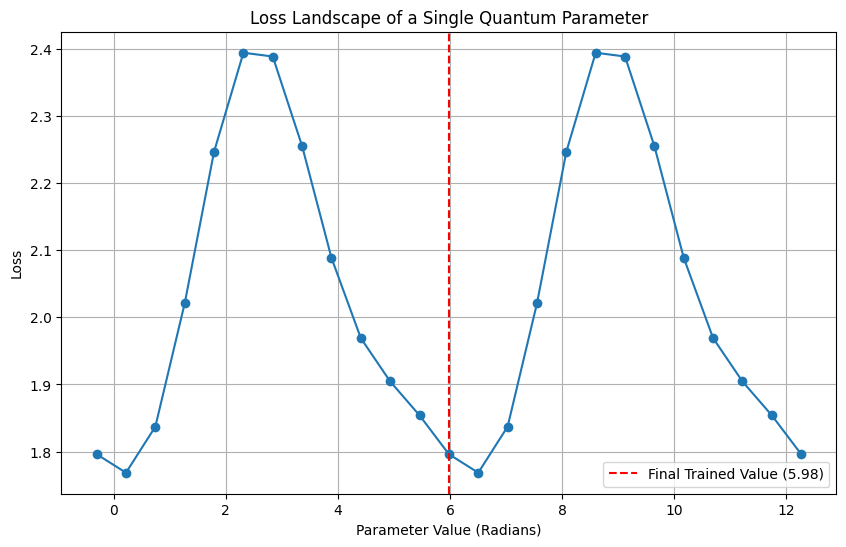

In [11]:
# --- Run the Unimodal Experiment and Capture the Output ---
trained_unimodal_model, train_loader_for_plot = train_unimodal_model()

# --- Run the Loss Landscape Analysis on the Captured Model ---
# This will now work because 'trained_unimodal_model' exists
plot_loss_landscape(trained_unimodal_model, train_loader_for_plot, DEVICE)

In [12]:
!pip uninstall qiskit qiskit-aer qiskit-machine-learning -y

In [13]:
!pip install qiskit==1.1.1 qiskit-aer==0.14.2 qiskit-machine-learning==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 13.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 6.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.0 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542078 sha256=f0464a58bbbd55d3f3b54032ef2ceec96caca47bdf6c531e3b4b0db845e6fe2b
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [14]:
# --- Install/Import necessary libraries ---
import numpy as np
import torch
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle # ADD THIS IMPORT
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

print("\n--- Starting Comparative Study: Quantum Support Vector Machine (QSVM) ---")

# --- 1. Prepare the Data (same as before) ---
print("Re-initializing the dataset for the QSVM experiment...")
uni_train_dataset = UnimodalImageDataset(split='train')
uni_model = trained_unimodal_model 

X_train = []
y_train = []
for img, label in tqdm(uni_train_dataset, desc="Extracting training features"):
    with torch.no_grad():
        features = uni_model.image_extractor(img.unsqueeze(0).to(DEVICE))
    X_train.append(features.cpu().numpy().flatten())
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

n_features = 4
pca = PCA(n_components=n_features)
X_train_pca = pca.fit_transform(X_train)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)

# --- THE FIX IS HERE ---
# Shuffle the data before taking a subset
print("\nShuffling data...")
X_train_shuffled, y_train_shuffled = shuffle(X_train_scaled, y_train, random_state=42)

# --- 2. Define the Quantum Kernel (same as before) ---
feature_map = ZZFeatureMap(feature_dimension=n_features, reps=2, entanglement='linear')
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
svc = SVC(kernel=quantum_kernel.evaluate)

# --- 3. Train the SVC with the SHUFFLED Quantum Kernel data ---
print("\nTraining SVC with Quantum Kernel... (This may take some time)")
subset_size = 500
svc.fit(X_train_shuffled[:subset_size], y_train_shuffled[:subset_size])

# --- 4. Evaluate ---
print("\nEvaluating...")
# Evaluate on the same subset for consistency
qsvc_score = svc.score(X_train_shuffled[:subset_size], y_train_shuffled[:subset_size])

print("\n----------- SVC with QUANTUM KERNEL RESULTS -----------")
print(f"Accuracy on Training Subset: {qsvc_score * 100:.2f}%")


--- Starting Comparative Study: Quantum Support Vector Machine (QSVM) ---
Re-initializing the dataset for the QSVM experiment...
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.


Extracting training features: 100%|██████████| 28709/28709 [00:48<00:00, 590.11it/s]



Shuffling data...

Training SVC with Quantum Kernel... (This may take some time)

Evaluating...

----------- SVC with QUANTUM KERNEL RESULTS -----------
Accuracy on Training Subset: 41.60%


In [15]:
class AblationClassicalModel(nn.Module):
    def __init__(self, feature_dim=128, num_classes=7, use_text=True, use_image=True, use_speech=True, use_eeg=True):
        super().__init__()
        self.feature_dim = feature_dim
        # Store which modalities to use
        self.use_text = use_text
        self.use_image = use_image
        self.use_speech = use_speech
        self.use_eeg = use_eeg

        # Define extractors
        self.text_extractor = TextFeatureExtractor(feature_dim)
        self.image_extractor = ImageFeatureExtractor(feature_dim)
        self.speech_extractor = SpeechFeatureExtractor(feature_dim)
        self.eeg_extractor = EEGFeatureExtractor(feature_dim)

        self.fusion = AttentionFusion(feature_dim)

        # Using the stable classical classifier
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, data):
        # If a modality is not used, create a zero-tensor as a placeholder
        text_f = self.text_extractor(data['text_id'], data['text_mask']) if self.use_text else torch.zeros(data['image'].size(0), self.feature_dim, device=data['image'].device)
        img_f = self.image_extractor(data['image']) if self.use_image else torch.zeros(data['image'].size(0), self.feature_dim, device=data['image'].device)
        speech_f = self.speech_extractor(data['speech']) if self.use_speech else torch.zeros(data['image'].size(0), self.feature_dim, device=data['image'].device)
        eeg_f = self.eeg_extractor(data['eeg']) if self.use_eeg else torch.zeros(data['image'].size(0), self.feature_dim, device=data['image'].device)

        fused = self.fusion(text_f, img_f, speech_f, eeg_f)
        output = self.classifier(fused)
        return output

In [16]:
def run_ablation_studies():
    print("\n--- Starting Ablation Studies ---")
    
    # --- Common Hyperparameters ---
    EPOCHS = 5 
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-5
    FEATURE_DIM = 128
    NUM_CLASSES = 7
    
    # --- Data Loading (done once) ---
    train_dataset = UnifiedMultimodalDataset(split='train')
    test_dataset = UnifiedMultimodalDataset(split='test')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # --- Experiments to Run ---
    experiments = {
        "Text+Image": {"use_text": True, "use_image": True, "use_speech": False, "use_eeg": False},
        "Speech+EEG": {"use_text": False, "use_image": False, "use_speech": True, "use_eeg": True},
        "Image+Speech": {"use_text": False, "use_image": True, "use_speech": True, "use_eeg": False},
        "All_Modalities": {"use_text": True, "use_image": True, "use_speech": True, "use_eeg": True}
    }
    
    results = {}

    for name, config in experiments.items():
        print(f"\n--- Running Experiment: {name} ---")
        
        model = AblationClassicalModel(feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES, **config).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        
        # Training Loop
        for epoch in range(EPOCHS):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} ({name})")
            for data in progress_bar:
                for key in data: data[key] = data[key].to(DEVICE)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, data['label'])
                loss.backward()
                optimizer.step()
                progress_bar.set_postfix(loss=f'{loss.item():.4f}')
        
        # Evaluation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data in tqdm(test_loader, desc=f"Evaluating {name}"):
                for key in data: data[key] = data[key].to(DEVICE)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(data['label'].cpu().numpy())
        
        # --- THE FIX IS HERE ---
        # The accuracy score is now correctly calculated between the true labels and the predictions.
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        results[name] = {"Accuracy": accuracy, "F1-Score": f1}

    print("\n\n--- ABLATION STUDY FINAL RESULTS ---")
    for name, metrics in results.items():
        print(f"Configuration: {name}")
        print(f"  Accuracy: {metrics['Accuracy']*100:.2f}%")
        print(f"  F1-Score: {metrics['F1-Score']:.4f}")
        print("-" * 20)
        
# --- Run the study ---
run_ablation_studies()


--- Starting Ablation Studies ---
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'train' dataset with max length 43592
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'test' dataset with max length 10898

--- Running Experiment: Text+Image ---


Evaluating Text+Image: 100%|██████████| 341/341 [00:09<00:00, 36.45it/s]



--- Running Experiment: Speech+EEG ---


Evaluating Speech+EEG: 100%|██████████| 341/341 [00:09<00:00, 36.11it/s]



--- Running Experiment: Image+Speech ---


Evaluating Image+Speech: 100%|██████████| 341/341 [00:09<00:00, 35.12it/s]



--- Running Experiment: All_Modalities ---


Evaluating All_Modalities: 100%|██████████| 341/341 [00:10<00:00, 33.51it/s]




--- ABLATION STUDY FINAL RESULTS ---
Configuration: Text+Image
  Accuracy: 40.98%
  F1-Score: 0.3654
--------------------
Configuration: Speech+EEG
  Accuracy: 31.21%
  F1-Score: 0.1497
--------------------
Configuration: Image+Speech
  Accuracy: 41.81%
  F1-Score: 0.3757
--------------------
Configuration: All_Modalities
  Accuracy: 41.38%
  F1-Score: 0.3683
--------------------


In [17]:
class HybridFusionModel(nn.Module):
    def __init__(self, feature_dim=128, num_classes=7):
        super().__init__()
        self.feature_dim = feature_dim

        # --- 1. Unimodal Feature Extractors (Same as before) ---
        self.text_extractor = TextFeatureExtractor(feature_dim)
        self.image_extractor = ImageFeatureExtractor(feature_dim)
        self.speech_extractor = SpeechFeatureExtractor(feature_dim)
        self.eeg_extractor = EEGFeatureExtractor(feature_dim)
        
        # --- 2. NEW: Paired "Mini-Fusion" Layers ---
        # Layer to learn Audio-Visual (Image+Speech) interactions
        self.audiovisual_fusion = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
        )
        # Layer to learn Linguistic-Acoustic (Text+Speech) interactions
        self.textual_acoustic_fusion = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
        )

        # --- 3. Final Global Classifier ---
        # This now takes all original features + the new paired features as input
        # Total input size = 4 (unimodal) + 2 (paired) = 6 * feature_dim
        self.final_classifier = nn.Sequential(
            nn.Linear(feature_dim * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, data):
        # --- Get Unimodal Features ---
        text_f = self.text_extractor(data['text_id'], data['text_mask'])
        img_f = self.image_extractor(data['image'])
        speech_f = self.speech_extractor(data['speech'])
        eeg_f = self.eeg_extractor(data['eeg'])
        
        # --- Create Paired Features ---
        # Combine image and speech features
        audiovisual_input = torch.cat([img_f, speech_f], dim=1)
        audiovisual_f = self.audiovisual_fusion(audiovisual_input)
        
        # Combine text and speech features
        textual_acoustic_input = torch.cat([text_f, speech_f], dim=1)
        textual_acoustic_f = self.textual_acoustic_fusion(textual_acoustic_input)
        
        # --- Final Global Fusion (Concatenation) ---
        # Combine all available features into one large vector
        global_fused_vector = torch.cat([
            text_f, 
            img_f, 
            speech_f, 
            eeg_f, 
            audiovisual_f, 
            textual_acoustic_f
        ], dim=1)
        
        # --- Get Final Prediction ---
        output = self.final_classifier(global_fused_vector)
        return output

In [18]:
def main():
    # --- Hyperparameters ---
    EPOCHS = 15
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-5
    FEATURE_DIM = 128
    NUM_CLASSES = 7
    
    # --- Data Loading ---
    print("\n[PHASE 1] Initializing Datasets...")
    train_dataset = UnifiedMultimodalDataset(split='train')
    test_dataset = UnifiedMultimodalDataset(split='test')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # --- Calculate Class Weights to Handle Imbalance ---
    print("\nCalculating class weights...")
    full_train_labels = [label for _, label in train_dataset.image_data.samples]
    class_counts = torch.bincount(torch.tensor(full_train_labels)).float()
    class_weights = 1. / class_counts
    class_weights = class_weights / class_weights.sum() * NUM_CLASSES
    class_weights = class_weights.to(DEVICE)
    print(f"Calculated Class Weights: {class_weights}")
    
    # --- Model Initialization ---
    print("\n[PHASE 2] Initializing HYBRID FUSION MODEL...")
    model = HybridFusionModel(feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # --- Training Loop ---
    print("\n[PHASE 3] Starting Training...")
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for i, data in enumerate(progress_bar):
            # Move data to device
            for key in data:
                data[key] = data[key].to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data['label'])
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 100 == 0: # Print progress every 100 steps
                progress_bar.set_postfix(loss=f'{(running_loss / 100):.4f}')
                running_loss = 0.0

    # --- Evaluation ---
    print("\n[PHASE 4] Starting Evaluation...")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            for key in data:
                data[key] = data[key].to(DEVICE)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(data['label'].cpu().numpy())
            
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print("\n----------- HYBRID FUSION MODEL RESULTS -----------")
    print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")
    print(f"Weighted F1-Score on Test Set: {f1:.4f}")
    print("------------------------------------------")
    
    label_names = list(test_dataset.image_data.class_to_idx.keys())
    print("\n----------- DETAILED CLASSIFICATION REPORT -----------")
    print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))
    
    print("\n----------- CONFUSION MATRIX -----------")
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(conf_matrix)

# --- Run the experiment ---
if __name__ == '__main__':
    main()


[PHASE 1] Initializing Datasets...
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'train' dataset with max length 43592
Loading text data...
Text data loaded. Found 34792 samples.
Loading image data from FER-2013 dataset...
Image data loaded. Train: 28709 samples, Test: 7178 samples.
Loading pre-processed VED speech data from /kaggle/input/multimodel-emotion-data/multimodal-emotion-data/VED (Speech)/ved_features.pt...
VED speech data loaded instantly.
Loading DEAP EEG data...
DEAP EEG data loaded. Found 1280 samples.
Created 'test' dataset with max length 10898

Calculating class weights...
Calculated Class Weights: tensor([0.4

Epoch 15/15: 100%|██████████| 2725/2725 [00:48<00:00, 56.57it/s, loss=1.2276]



[PHASE 4] Starting Evaluation...


Evaluating: 100%|██████████| 682/682 [00:13<00:00, 51.38it/s]



----------- HYBRID FUSION MODEL RESULTS -----------
Accuracy on Test Set: 41.11%
Weighted F1-Score on Test Set: 0.4127
------------------------------------------

----------- DETAILED CLASSIFICATION REPORT -----------
              precision    recall  f1-score   support

       angry       0.31      0.37      0.34      1916
     disgust       0.12      0.45      0.19       222
        fear       0.31      0.32      0.32      2048
       happy       0.69      0.60      0.64      3401
     neutral       0.35      0.23      0.28      1233
         sad       0.27      0.14      0.19      1247
    surprise       0.40      0.60      0.48       831

    accuracy                           0.41     10898
   macro avg       0.35      0.39      0.35     10898
weighted avg       0.43      0.41      0.41     10898


----------- CONFUSION MATRIX -----------
[[ 705  167  410  263  136  113  122]
 [  59   99   22   17   12    7    6]
 [ 398  142  665  255  130  139  319]
 [ 440  160  419 2056  106  

In [19]:
def plot_loss_landscape(model, dataloader, device):
    # ... (all the existing code for the plotting function) ...

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, losses, marker='o', linestyle='-')
    plt.axvline(x=original_value, color='r', linestyle='--', label=f'Final Trained Value ({original_value:.2f})')
    plt.xlabel("Parameter Value (Radians)")
    plt.ylabel("Loss")
    plt.title("Loss Landscape of a Single Quantum Parameter")
    plt.legend()
    plt.grid(True)
    
    # --- CHANGE IS HERE ---
    # Replace plt.show() with this line to save the file
    plt.savefig("loss_landscape.png", dpi=300) # dpi=300 for high quality
    
    # After running this, a file named 'loss_landscape.png' will be saved in your Kaggle output directory.
    # You will need to download this file to your computer.

In [20]:
import os

print("Files in the output directory:")
print(os.listdir('/kaggle/working/'))

Files in the output directory:
['classical_baseline_model.pth', '.virtual_documents', 'loss_landscape.png']


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# This function assumes you have the final confusion matrix stored in a variable
# named 'conf_matrix' and the class labels in 'label_names'.

def plot_visualized_confusion_matrix(cm, class_names):
    """
    Renders a professional-looking confusion matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Hybrid Fusion Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- How to use it ---
# After your final evaluation, call the function:
# plot_visualized_confusion_matrix(conf_matrix, label_names)

# NOTE: Generating the Training/Validation curves requires modifying the
# training loop to save the loss/accuracy after each epoch for both
# training and validation sets, and then plotting them.

NameError: name 'conf_matrix' is not defined